In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy as sym
from sympy.vector import CoordSys3D
from sympy.utilities.lambdify import lambdastr, implemented_function, lambdify
from glob import glob

from sys import path
path.insert(0, "lib")
from colorline import colorline

%load_ext autoreload
%autoreload 2

In [2]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer, ExponentialConvectionTerm

from fipy.tools import numerix

## Tools

In [3]:
def get_coeffs(q, print_func=False):
    """
    q: function of w (learned variable) and w0 (fixed, free parameter)
    """
    w, w0, v, ve, l, b = sym.symbols('w w0 v ve l b')
    N = CoordSys3D('N')
    grad_q = sym.diff(q, w)
    h = -l*v*q*grad_q
    g = (l/sym.sqrt(b))*(-v*q*grad_q*N.i + sym.sqrt(v*ve/2)*grad_q*N.j)
    d1 = h + g.dot(sym.diff(g, w))
    d2 = g.dot(g)
    convection = -d1 + sym.diff(d2, w)
    if print_func:
        display("convection term:", sym.factor(convection))
        display("diffusion term:", d2)
    return lambdify((l, v, ve, w0, b, w), convection), lambdify((l, v, ve, w0, b, w), d2)

In [4]:
w, w0 = sym.symbols('w w0')
q = (w-w0)
convection, d2 = get_coeffs(q, print_func=True)

'convection term:'

l*v*(b + l*v)*(w - w0)/b

'diffusion term:'

l**2*v**2*(w - w0)**2/b + l**2*(v*ve)/(2*b)

In [5]:
l = 0.01
v = 1.
std_e = 10
ve = std_e**2.
w0 = 0.5
b = 20
convection(l, v, ve, w0, b, .5)

0.0

In [6]:
def get_FP_data_init(q, nw, lr, v, ve, w0, b, L, dt, steps, w_left, w_right, zero_prob_left, zero_prob_right):
    """
    Init is 1 inside the interval w_left <= w <= w_right and 0 outside of it

    zero_prob_left: Dirichlet boundary condition on the left end of the interval, with p(left_end) = 0
    """
    
    convection, d2 = get_coeffs(q)
    
    mesh = Grid1D(nx=nw, Lx=L)
    
    P = CellVariable(mesh=mesh, name=r"$P$")
    P.value = 0.
    w = mesh.cellCenters[0]

    def creneau(w, left, right):
        k = 1./(2.*(right-left))
        return np.where(w < left, -k, k) + np.where(w > right, -k, k)
    
    P.setValue(creneau(w, w_left, w_right))

    if zero_prob_left:
        # set zero probability on the left end of the simulation interval
        P.constrain(0., where=mesh.facesLeft)
    if zero_prob_right:
        # set zero probability on the left end of the simulation interval
        P.constrain(0., where=mesh.facesRight)

    w = mesh.cellCenters[0]
    D2 = d2(lr, v, ve, w0, b, w)
    
    w = mesh.faceCenters[0]
    minusD1plusgradD2 = convection(lr, v, ve, w0, b, w)
    # unit vector
    u = FaceVariable(mesh=mesh, value = 1., rank=1)
    
    # explicit
    eq = TransientTerm() == DiffusionTerm(CellVariable(mesh=mesh, value = D2)) + ExponentialConvectionTerm(u * FaceVariable(mesh=mesh, value = minusD1plusgradD2))

    Ps = [P.copy()]
    for step in range(steps):
        eq.solve(var=P, dt=dt)
        Ps.append(P.copy())

    return mesh.x, Ps

In [7]:
class SGD:
    """
    Exact SGD dynamics
    """
    def __init__(self, std_epsilon, lr, q, grad_q, w_init, batchsize, seed):
        """
        lr: learning rate
        q: model
        grad_q: gradient of the model
        """
        self.lr = lr
        self.q = q
        self.grad_q = grad_q
        self.nb = batchsize
        self.w = [w_init]
        self.state = np.random.RandomState(seed=seed)
        self.std_epsilon = std_epsilon
        
    def update(self, w_old):
        xb = self.state.normal(size=self.nb)
        yb = self.state.normal(size=self.nb, scale=self.std_epsilon)
        
        xi_xx = np.mean(xb*xb)
        xi_xy = np.mean(xb*yb)
        return w_old - self.lr*(xi_xx * self.q(w_old) - xi_xy) * self.grad_q(w_old)
    
    def evolve(self, nstep):
        wc = self.w[-1]
        for _ in range(nstep):
            wc = self.update(wc)
            self.w.append(wc)
            if np.isnan(wc):
                break


## Linear model + comparison with SGD

In [189]:
w, w0 = sym.symbols('w w0')
q = (w-w0)*(w**2+1)

nw = 100
lr = 0.01
v = 1.
stde = 1.2
ve = stde**2.
w0 = 0.5
b = 20
L = 1
dt = 1.
steps = 10

# uniform density in the simulation interval
w_left, w_right = 0, L
# zero flux boundary conditions
zero_prob_left, zero_prob_right = False, False
x, Ps = get_FP_data_init(q, nw, lr, v, ve, w0, b, L, dt, steps, w_left, w_right, zero_prob_left, zero_prob_right)

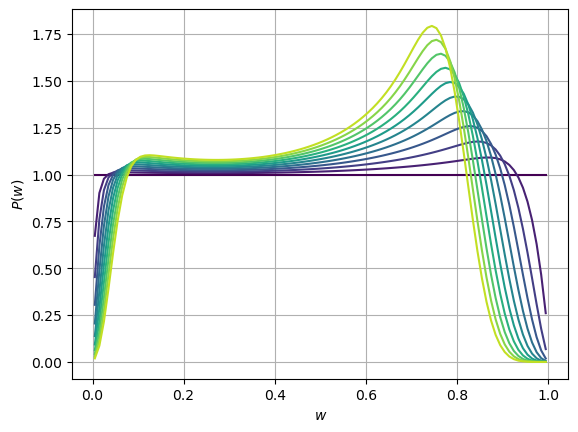

In [190]:
cmap = plt.get_cmap('viridis')
for i, P in enumerate(Ps):
    plt.plot(x, P, color = cmap(i / len(Ps)))
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()

### Finite time comparisons

In [191]:
sgd_datas = []
stdes = [1.2]
for stde in stdes:
    files = glob(f'data/nonlin_stde{stde:g}*.dat')
    sgd_data = np.array([np.loadtxt(file) for file in files])
    sgd_datas.append(sgd_data)

In [207]:
w, w0 = sym.symbols('w w0')
q = (w-w0)*(w**2+1)

nw = 500
lr = 0.01
v = 1.
w0 = 0.5
b = 20
L = 1
dt = .003
steps = int(10/dt)

fp_datas = []
for stde in stdes:
    ve = stde**2.
    # uniform density in the simulation interval
    w_left, w_right = 0, L
    # zero flux boundary conditions
    zero_prob_left, zero_prob_right = False, False
    x, Ps = get_FP_data_init(q, nw, lr, v, ve, w0, b, L, dt, steps, w_left, w_right, zero_prob_left, zero_prob_right)
    fp_datas.append(Ps)

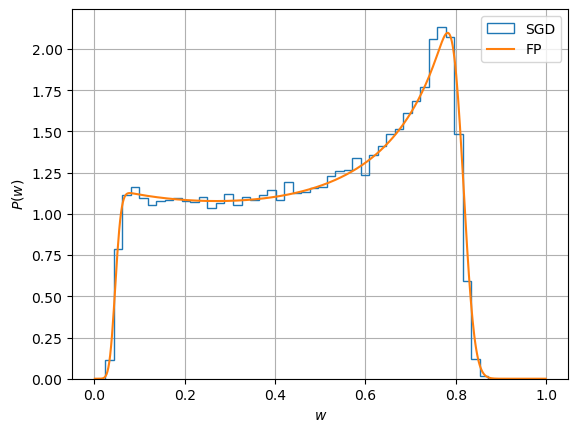

In [208]:
for sgd_data, Ps, stde in zip(sgd_datas, fp_datas, stdes):
    plt.hist(sgd_data.T[-1], histtype='step', density=True, bins='auto', label='SGD')
    plt.plot(x, Ps[-1], label='FP')
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()

# 1D linear model

In [209]:
w, w0 = sym.symbols('w w0')
q = w-w0

nw = 500
lr = 0.01
v = 1.
stde = 1.
ve = stde**2.
w0 = 0.5
b = 100
L = 1
dt = 1.
steps = 1000

# uniform density in the simulation interval
w_left, w_right = 0, L
# zero flux boundary conditions
zero_prob_left, zero_prob_right = False, False

Pdata = []
for b in [100]:
    x, Ps = get_FP_data_init(q, nw, lr, v, ve, w0, b, L, dt, steps, w_left, w_right, zero_prob_left, zero_prob_right)
    Pdata.append(Ps[-1])

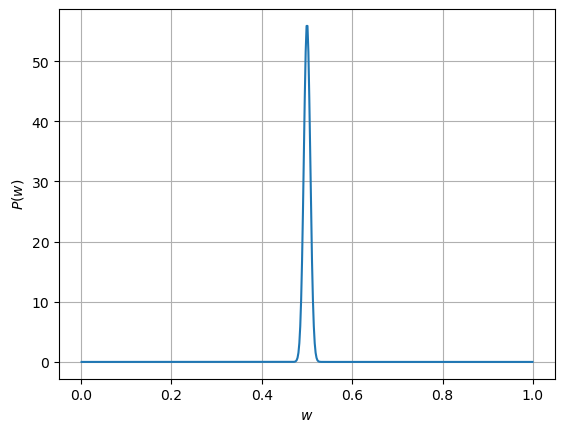

In [210]:
for P in Pdata:
    plt.plot(x, P)
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()

## Comparison with SGD

In [224]:
def q(w):
    return w-.5
    
def grad_q(w):
    return 1.

def get_data(lr, batchsize):
    w_init = .1
    seed = 42
    std_e = 1.
    S = SGD(std_e, lr, q, grad_q, w_init, batchsize, seed)
    S.evolve(10**6)
    return S.w

In [225]:
ws = [get_data(lr = 0.01, batchsize = b) for b in [1, 10, 100]]

In [217]:
ws = np.array(ws)

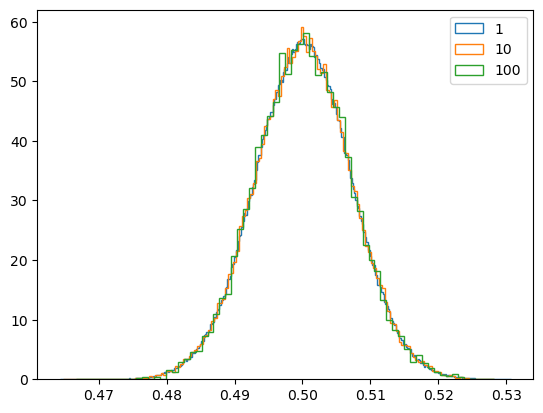

In [218]:
# histograms for different autocorrelation times
ti = 10**3
for tc in [1, 10, 100]:
    data = ws[2][ti::tc]
    plt.hist(data, bins='auto', histtype='step', label=f'{tc}', density=True)
plt.legend()
plt.show()

In [219]:
w, w0 = sym.symbols('w w0')
q = w-w0

nw = 500
lr = 0.01
v = 1.
stde = 1.
ve = stde**2.
w0 = 0.5
b = 100
L = 1
dt = 1.
steps = 1000

# uniform density in the simulation interval
w_left, w_right = 0, L
# zero flux boundary conditions
zero_prob_left, zero_prob_right = False, False

Pdata = []
for b in [1, 10, 100]:
    x, Ps = get_FP_data_init(q, nw, lr, v, ve, w0, b, L, dt, steps, w_left, w_right, zero_prob_left, zero_prob_right)
    Pdata.append(Ps[-1])

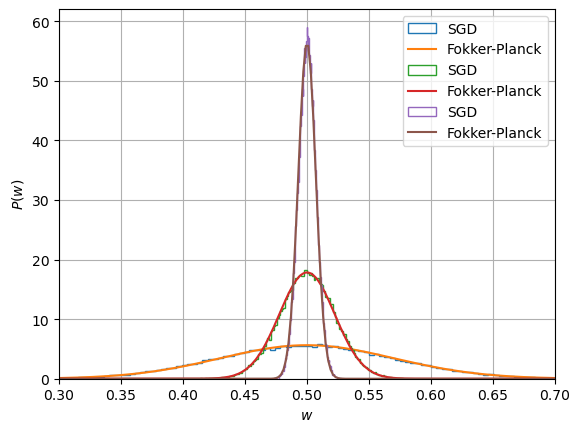

In [223]:
ti = 10**3
tc = 10
for w, P in zip(ws, Pdata):
    data = w[ti::tc]
    plt.hist(data, bins='auto', histtype='step', label='SGD', density=True)

    plt.plot(x, P, label='Fokker-Planck')
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.legend()
plt.xlim(0.3, 0.7)
plt.grid()
plt.savefig("dynamics_linear_model.png", bbox_inches="tight", dpi=150)

## Singular minimum

In [8]:
def simulate_sing(lr, dt, time, a, t, nw, w_left, w_right, zero_prob_left, zero_prob_right):
    """
    t: translation of the origin
    lr: learning rate
    dt: iterations per unit time
    time: total time simulated
    a: half distance between regular and singular minima
    nw: number of w points
    w_left, w_right: boundaries of the initial interval
    """
    
    b = 20
    steps = int(time/dt)
    v = ve = 1
    
    w, w0 = sym.symbols('w w0')
    # potential
    q = (w-t/2)**a
    # total length of the interval simulated
    L = t
    
    x, Ps = get_FP_data_init(q, nw, lr, v, ve, a, b, L, dt, steps, w_left, w_right, zero_prob_left, zero_prob_right)
    return q, x, Ps

In [82]:
def q(w):
    return w**2.
    
def grad_q(w):
    return 2.*w

def get_data_sing(seed, timesteps):
    lr = .05
    state = np.random.RandomState(seed=seed)
    w_init = state.uniform(-.5,.5)
    std_e = 1.
    batchsize = 20
    S = SGD(std_e, lr, q, grad_q, w_init, batchsize, seed)
    S.evolve(timesteps)
    return S.w

In [87]:
nsamp = 10**5
tmax = 20
sgd_data = np.array([get_data_sing(seed, tmax) for seed in range(nsamp)])

In [126]:
lr = .05

time = 20
# singularity exponent
a = 2
x, P = dict(), dict()
ts = [4]
dts = [.1]
nws = [500]
zero_prob_left, zero_prob_right = True, False

xs, Ps = [], []
for t, nw, dt in zip(ts, nws, dts):
    w_left, w_right = -.5 + t/2, .5 + t/2
    
    q, x_tmp, P_tmp = simulate_sing(lr, dt, time, a, t, nw, w_left, w_right, zero_prob_left, zero_prob_right)
    xs.append(x_tmp)
    Ps.append(P_tmp)

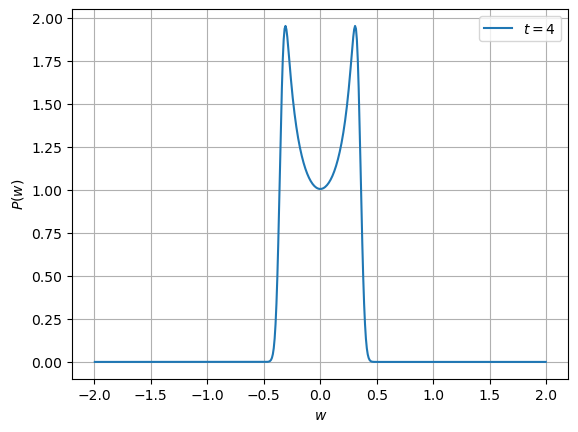

In [131]:
fig, ax = plt.subplots()

for t, nw, dt, x, P in zip(ts, nws, dts, xs, Ps):
    

    # time index
    i = -1
    plt.plot(x-t/2, P[i], label=f"$t={t}$")

# ax.set_yscale('log')
plt.xlabel('$w$')
plt.ylabel('$P(w)$')
plt.legend()
plt.grid()
plt.savefig('stationary_distrib.png', bbox_inches='tight', dpi=150)

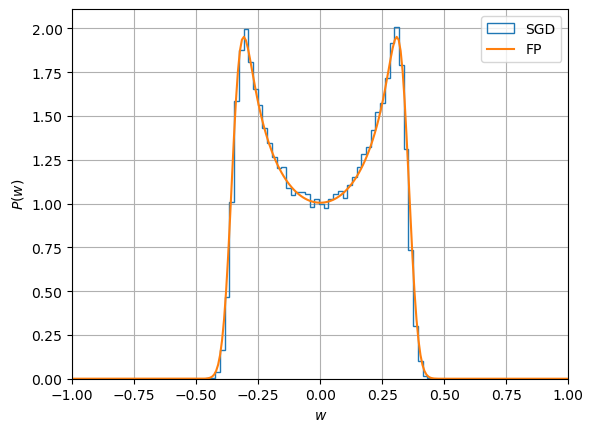

In [128]:
plt.hist(sgd_data.T[-1], histtype='step', density=True, bins='auto', label='SGD')
plt.plot(x-t/2, Ps[0][-1], label='FP')
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.xlim(-1,1)
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()

## Double well

In [107]:
def simulate(lr, dt, time, a, t, nw, w_left, w_right, zero_prob_left, zero_prob_right):
    """
    t: translation of the origin
    lr: learning rate
    dt: iterations per unit time
    time: total time simulated
    a: half distance between regular and singular minima
    nw: number of w points
    w_left, w_right: boundaries of the initial interval
    """
    
    b = 20
    steps = int(time/dt)
    v = 1
    ve = 2
    
    w, w0 = sym.symbols('w w0')
    # potential
    q = (w-t)*(w-2*w0-t)**2.
    # watershed line (maximum of the potential)
    wmax = (2*t + 2*a+t)/3
    # total length of the interval simulated
    L = 2*a+t+4
    
    x, Ps = get_FP_data_init(q, nw, lr, v, ve, a, b, L, dt, steps, w_left, w_right, zero_prob_left, zero_prob_right)
    return q, x, Ps

### Simulation box size

Findings so far. The slope depends on:
* Simulation box size (if not large enough)
* Boundary conditions
* nw and dt

In [108]:
lr = .01
dt = .01
time = 50
nw = 5000
a = 1.9
x, P = dict(), dict()
ts = [2]
zero_prob_left, zero_prob_right = True, True
for t in ts:
    wmax_reg = t
    wmax_sing = 2*a + t
    wbarrier = (2*wmax_reg + wmax_sing)/3
    w_left, w_right = wmax_reg - 1, wmax_reg
    
    q, x[t], P[t] = simulate(lr, dt, time, a, t, nw, w_left, w_right, zero_prob_left, zero_prob_right)

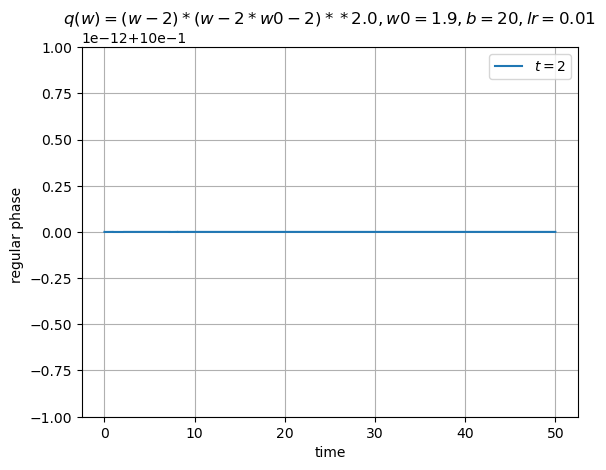

In [109]:
fig, ax = plt.subplots()
b = 20
for t in ts:
    data = np.array(P[t])
    # index such that i < icut are points classified as "in the regular phase"
    wleft = t
    wright = 2*a + t
    wmax = (2*wleft + wright)/3
    L = 2*a+t+2
    icut = int(nw*wmax/L)
    # dynamic normalization factor (sum might depend on time)
    reg = np.sum(data.T[:icut], axis = 0)/np.sum(data, axis=1)

    # remove inital points
    i0 = 0
    filt = reg[i0:]
    plt.plot(dt*(np.arange(len(filt))+i0), filt, label=f'$t={t}$')

# ax.set_yscale('log')
plt.xlabel('time')
plt.ylabel('regular phase ')
plt.title(f'$q(w)={q}, w0={a}, b={b}, lr={lr}$')
plt.legend()
plt.grid()
plt.savefig('escape_fp.png', dpi=150)
plt.show()

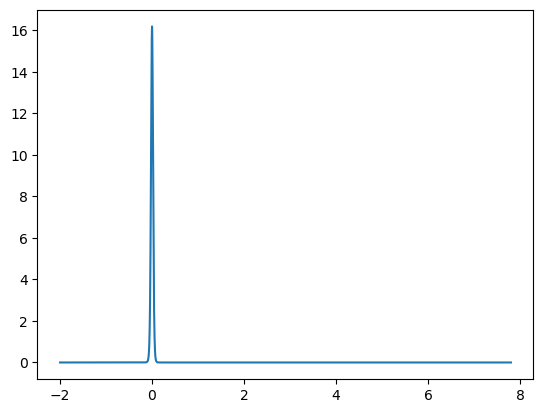

In [110]:
i = -1
plt.plot(x[t]-t, P[t][i])
# plt.yscale('log')
plt.show()

In [111]:
def SGD_evolve(seed, nsteps):
    std_e = 2
    lr = 0.01
    a = 1.9
    qSGD = lambda w: w*(w-2*a)**2.
    grad_q = lambda w: (w-2*a)**2. + 2.*w*(w-2*a)
    b = 20

    state = np.random.RandomState(seed=seed)
    wmax_reg = 0
    wmax_sing = 2*a
    wbarrier = (2*wmax_reg + wmax_sing)/3
    w_left, w_right = wmax_reg - 1, wmax_reg

    w_init = np.random.uniform(w_left, w_right)
    
    S = SGD(std_e, lr, qSGD, grad_q, w_init, b, seed)

    S.evolve(nsteps)

    return S.w

In [78]:
nsteps = 150
nseeds = 10**4
sgd_data = [SGD_evolve(seed, nsteps) for seed in range(nseeds)]

/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_69221/279736895.py:5: RuntimeWarning: overflow encountered in scalar power
  qSGD = lambda w: w*(w-2*a)**2.
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_69221/279736895.py:6: RuntimeWarning: overflow encountered in scalar power
  grad_q = lambda w: (w-2*a)**2. + 2.*w*(w-2*a)
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_69221/279736895.py:6: RuntimeWarning: overflow encountered in scalar multiply
  grad_q = lambda w: (w-2*a)**2. + 2.*w*(w-2*a)
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_69221/2695911418.py:25: RuntimeWarning: invalid value encountered in scalar subtract
  return w_old - self.lr*(xi_xx * self.q(w_old) - xi_xy) * self.grad_q(w_old)
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_69221/2695911418.py:25: RuntimeWarning: overflow encountered in scalar multiply
  return w_old - self.lr*(xi_xx * self.q(w_old) - xi_xy) * self.grad_q(w_old)
/var/folders/lb/0wvyvp693x9

In [84]:
filt_data = []
for d in sgd_data:
    if np.isnan(d).any() or np.isinf(d).any():
        pass
    else:
        filt_data.append(d)
filt_data = np.array(filt_data)

100


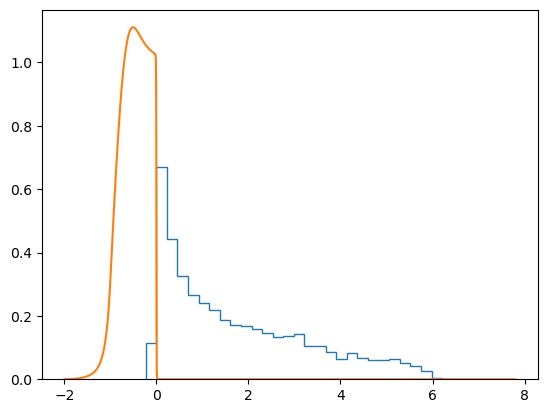

In [113]:
i = 1
plt.hist(filt_data.T[i], density=True, bins='auto', histtype='step')
ifp = int(i/dt)
print(ifp)
ifp = 1
plt.plot(x[t]-t, P[t][ifp])
plt.show()

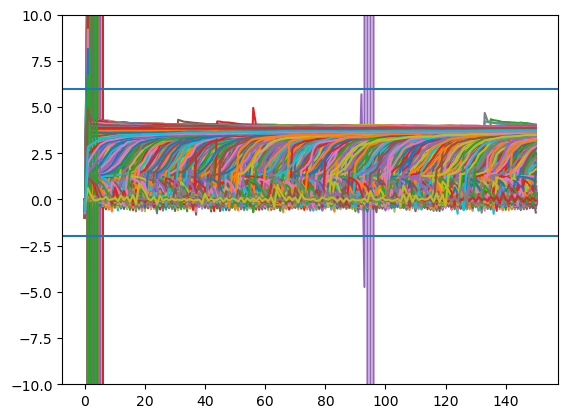

In [98]:
for d in sgd_data:
    plt.plot(d)
plt.ylim(top=10, bottom=-10)
plt.axhline(-2)
plt.axhline(6)
plt.show()

In [76]:
np.shape(filt_data)

(9299, 151)

In [77]:
np.shape(data)

(5001, 2000)

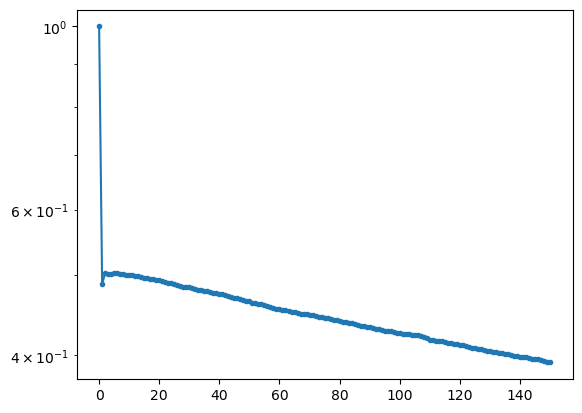

In [44]:
a = 1.8
wmax_reg = 0
wmax_sing = 2*a
wbarrier = (2*wmax_reg + wmax_sing)/3
reg = np.mean(filt_data < wbarrier, axis = 0)

fig, ax = plt.subplots()
ax.plot(reg, '.-')
ax.set_yscale('log')
plt.show()

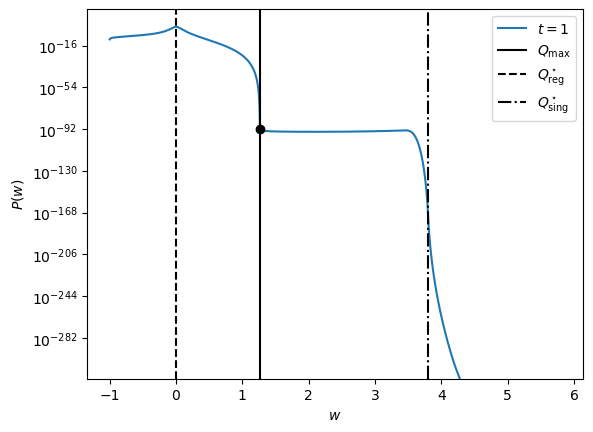

In [91]:
fig, ax = plt.subplots()

for t in ts:
    
    wleft = t
    wright = 2*a + t
    wmax = (2*wleft + wright)/3
    L = 2*a+t+2
    icut = int(nw*wmax/L)


    # time index
    i = -1
    plt.plot(x[t]-t, P[t][i], label=f"$t={t}$")

    # check that cut is at the correct place
    plt.plot((x[t]-t)[icut], P[t][i][icut], 'ko')

plt.axvline(x=wmax-t, color='k', label=r'$Q_\mathrm{max}$')
plt.axvline(x=0, ls='--', color='k', label=r'$Q^\star_\mathrm{reg}$')
plt.axvline(x=2*a, ls='-.', color='k', label=r'$Q^\star_\mathrm{sing}$')
ax.set_yscale('log')
plt.xlabel('$w$')
plt.ylabel('$P(w)$')
plt.legend()
plt.savefig('stationary_distrib.png', bbox_inches='tight', dpi=150)

### Comparison to numerics

In [7]:
sgddat = np.loadtxt("sgd_escapefreq_b20_lr0.01_a2.0_stde1.0_nseeds20000_b20.dat")

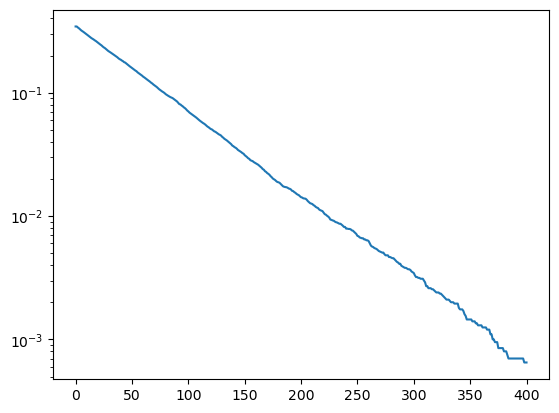

In [8]:
fig, ax = plt.subplots()
ax.plot(sgddat)
ax.set_yscale('log')

In [70]:
lr = 0.1
dt = .1
time = 200
nw = 5000
a = 1
x, P = dict(), dict()
ts = [5, 10, 20]
for t in ts:
    wl = t-1
    wr = t
    x[t], P[t] = simulate(lr, dt, time, a, t, nw, wl, wr)

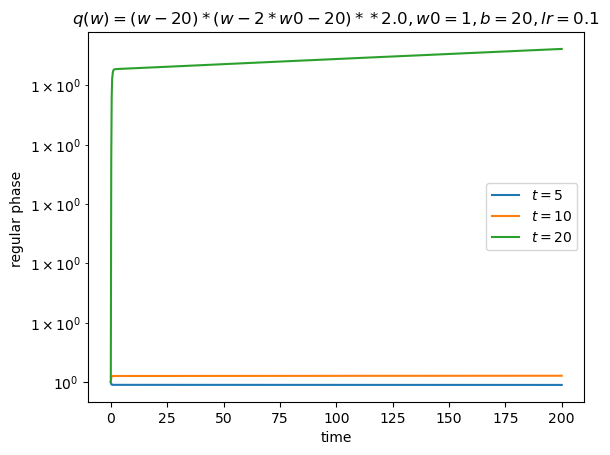

In [71]:
fig, ax = plt.subplots()
for t in ts:
    data = np.array(P[t])
    # index such that i < icut are points classified as "in the regular phase"
    wleft = t
    wright = 2*a + t
    wmax = (2*wleft + wright)/3
    L = 2*a+t+2
    icut = int(nw*wmax/L)
    # normalization factor
    norm = np.sum(data[0])
    reg = np.sum(data[:].T[:icut]/norm, axis = 0)

    # remove inital points
    i0 = 0
    filt = reg[i0:]
    plt.plot(dt*(np.arange(len(filt))+i0), filt, label=f'$t={t}$')

w, w0 = sym.symbols('w w0')
q = (w-t)*(w-2*w0-t)**2.
b = 20
ax.set_yscale('log')
plt.xlabel('time')
plt.ylabel('regular phase ')
plt.title(f'$q(w)={q}, w0={a}, b={b}, lr={lr}$')
plt.legend()
plt.savefig('escape_fp.png', dpi=150)
plt.show()

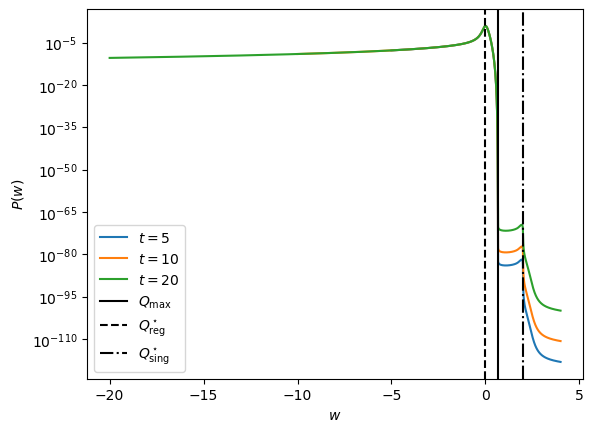

In [73]:
fig, ax = plt.subplots()

for t in ts:
    
    wleft = t
    wright = 2*a + t
    wmax = (2*wleft + wright)/3
    
    plt.plot(x[t]-t, P[t][-1], label=f"$t={t}$")

plt.axvline(x=wmax-t, color='k', label=r'$Q_\mathrm{max}$')
plt.axvline(x=0, ls='--', color='k', label=r'$Q^\star_\mathrm{reg}$')
plt.axvline(x=2*a, ls='-.', color='k', label=r'$Q^\star_\mathrm{sing}$')
ax.set_yscale('log')
plt.xlabel('$w$')
plt.ylabel('$P(w)$')
# plt.xlim(-0.2, 0.2)
plt.legend()
plt.savefig('stationary_distrib.png', bbox_inches='tight', dpi=150)